### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.population.networks.household_workplace import HouseholdWorkplacePopulation
from codit.population.covid import PersonCovid
import codit.society as society
import codit.config

### Baseline config of the simulation

In [6]:
codit.config.print_baseline_config()

DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY 0.025
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


We are going to work with a small town of a few thousand people.

In [7]:
pop = HouseholdWorkplacePopulation(56000, society.Society(), person_type=PersonCovid)

2021-01-15 19:10:14,268 INFO:Building households
2021-01-15 19:10:14,269 INFO:Mean size is 2.736842105263158
2021-01-15 19:10:15,005 INFO:Done households, now moving on to workplaces
2021-01-15 19:10:15,006 INFO:Mean size is 5.615384615384615
2021-01-15 19:10:16,360 INFO:Composing households and workplaces


Randomly, we put them into fixed and overlapping social groupings, where each person has a small network.

In [8]:
nets = [len(p.contacts) for p in pop.people]

In [9]:
np.mean(nets)

11.737928571428572

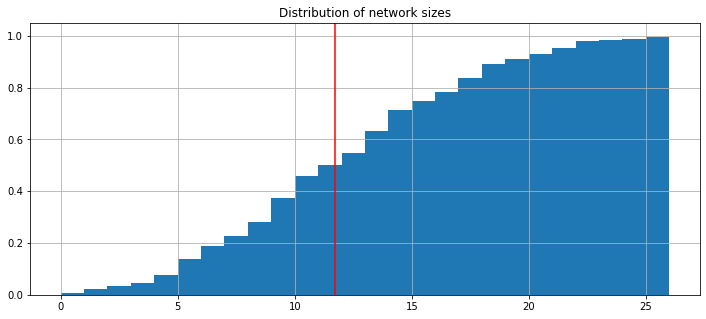

In [10]:
plt.hist(nets, cumulative=True, density=True, bins=2000)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

### Finally ready to simulate:

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [11]:
POP_SIZE = 56000
PREVALENCE = 1/560 * 4
SCALE_SETTINGS = dict(n_days = 201, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 201,
 'pop_size': 56000,
 'seed_size': 400,
 'population': <codit.population.networks.household_workplace.HouseholdWorkplacePopulation at 0x7fc9f92bf9d0>}

Our baseline simulation is of a runaway infection.

We start with 400 people infected in a population of 56,000.

We begin by studying a society where people don't know whether or how to self-isolate:

In [12]:
s_basic = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0))
o_basic = Outbreak(s_basic, Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:10:24,270 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:10:25,010 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0049
2021-01-15 19:10:31,293 INFO:Day 51, prop infected is 0.34, prop infectious is 0.0780
2021-01-15 19:10:38,061 INFO:Day 101, prop infected is 0.64, prop infectious is 0.0156
2021-01-15 19:10:43,693 INFO:Day 151, prop infected is 0.66, prop infectious is 0.0003
2021-01-15 19:10:48,996 INFO:Day 201, prop infected is 0.66, prop infectious is 0.0000


2021-01-15 19:10:49,128 INFO:NumExpr defaulting to 8 threads.
2021-01-15 19:10:49,180 INFO: Realized R0 of early infections is 1.43
2021-01-15 19:10:49,181 INFO: 65.7 percent of the proportion was infected during the epidemic


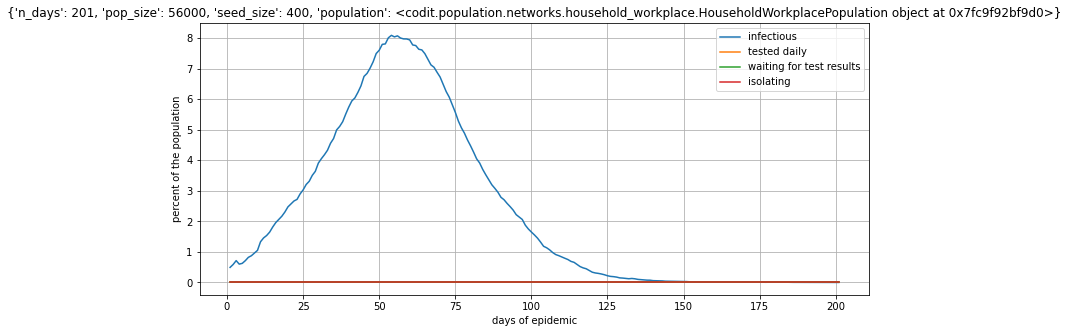

In [13]:
o_basic.plot(title=str(SCALE_SETTINGS))

Lets put that on a log scale:

2021-01-15 19:10:49,822 INFO: Realized R0 of early infections is 1.43
2021-01-15 19:10:49,823 INFO: 65.7 percent of the proportion was infected during the epidemic


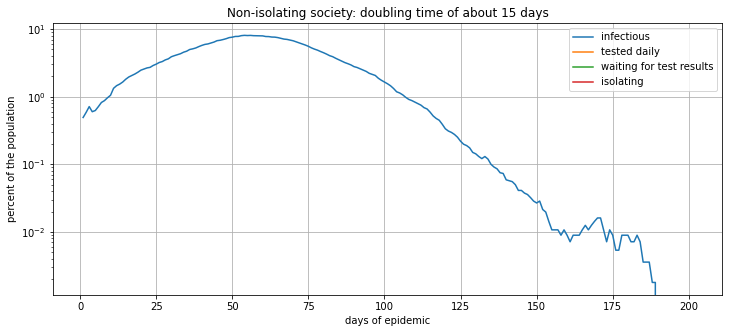

In [14]:
o_basic.plot(logy=True, title='Non-isolating society: doubling time of about 15 days')

Next, suppose that people know to isolate if they show symptoms, and 75% do so - this is similar to what is going on in the UK now:

In [15]:
s_isolate = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0.75))
o_isolate = Outbreak(s_isolate, Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:10:50,429 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:10:51,182 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-15 19:10:57,114 INFO:Day 51, prop infected is 0.05, prop infectious is 0.0045
2021-01-15 19:11:03,201 INFO:Day 101, prop infected is 0.08, prop infectious is 0.0044
2021-01-15 19:11:09,144 INFO:Day 151, prop infected is 0.10, prop infectious is 0.0020
2021-01-15 19:11:14,999 INFO:Day 201, prop infected is 0.11, prop infectious is 0.0004


2021-01-15 19:11:15,078 INFO: Realized R0 of early infections is 1.01
2021-01-15 19:11:15,079 INFO: 11.0 percent of the proportion was infected during the epidemic


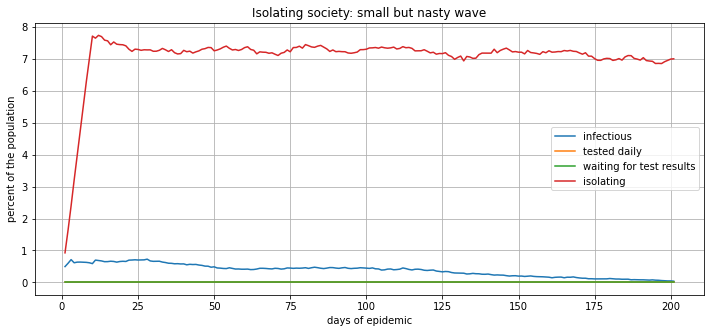

In [16]:
o_isolate.plot(title='Isolating society: small but nasty wave')

So, now we can add testing:
 * initially, here, lets suppose that positive test results are just ignored, while -ve results let people out of isolation:

In [17]:
s_testignored = society.TestingSociety(config=dict(PROB_ISOLATE_IF_TESTPOS=0))
o_testignored = Outbreak(s_testignored, Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:11:15,305 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:11:16,091 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-15 19:11:23,100 INFO:Day 51, prop infected is 0.07, prop infectious is 0.0090
2021-01-15 19:11:29,817 INFO:Day 101, prop infected is 0.12, prop infectious is 0.0057
2021-01-15 19:11:36,667 INFO:Day 151, prop infected is 0.15, prop infectious is 0.0023
2021-01-15 19:11:43,088 INFO:Day 201, prop infected is 0.16, prop infectious is 0.0013


2021-01-15 19:11:43,183 INFO: Realized R0 of early infections is 1.06
2021-01-15 19:11:43,183 INFO: 16.1 percent of the proportion was infected during the epidemic


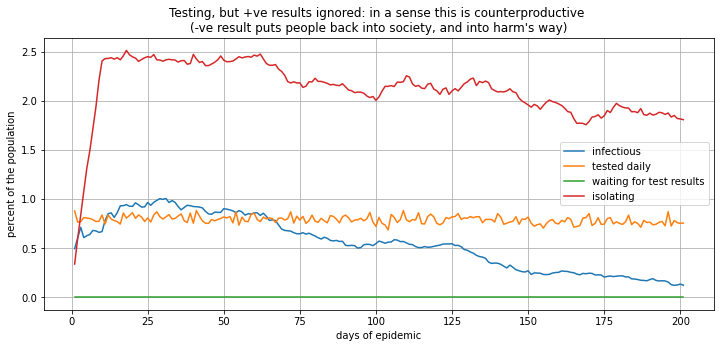

In [18]:
o_testignored.plot(title="Testing, but +ve results ignored: in a sense this is counterproductive \n"
                         "(-ve result puts people back into society, and into harm's way)")

 * Now suppose that people respond to test results, some of the time:

In [19]:
o_test = Outbreak(society.TestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:11:43,402 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:11:44,180 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-01-15 19:11:51,189 INFO:Day 51, prop infected is 0.06, prop infectious is 0.0076
2021-01-15 19:11:57,776 INFO:Day 101, prop infected is 0.10, prop infectious is 0.0033
2021-01-15 19:12:04,803 INFO:Day 151, prop infected is 0.11, prop infectious is 0.0016
2021-01-15 19:12:11,217 INFO:Day 201, prop infected is 0.12, prop infectious is 0.0006


2021-01-15 19:12:11,302 INFO: Realized R0 of early infections is 1.06
2021-01-15 19:12:11,303 INFO: 12.1 percent of the proportion was infected during the epidemic


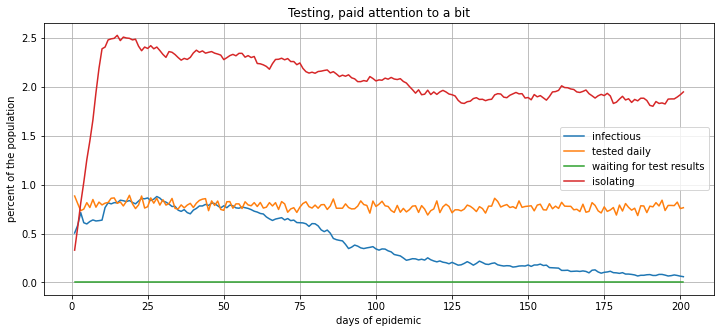

In [20]:
o_test.plot(title="Testing, paid attention to a bit")

We add contact-tracing and isolation:

In [21]:
o_test_trace = Outbreak(society.TestingTracingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:12:11,506 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:12:12,295 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-15 19:12:19,357 INFO:Day 51, prop infected is 0.04, prop infectious is 0.0020
2021-01-15 19:12:25,994 INFO:Day 101, prop infected is 0.04, prop infectious is 0.0003
2021-01-15 19:12:32,519 INFO:Day 151, prop infected is 0.04, prop infectious is 0.0000
2021-01-15 19:12:39,336 INFO:Day 201, prop infected is 0.04, prop infectious is 0.0000


2021-01-15 19:12:39,407 INFO: Realized R0 of early infections is 0.88
2021-01-15 19:12:39,408 INFO: 4.2 percent of the proportion was infected during the epidemic


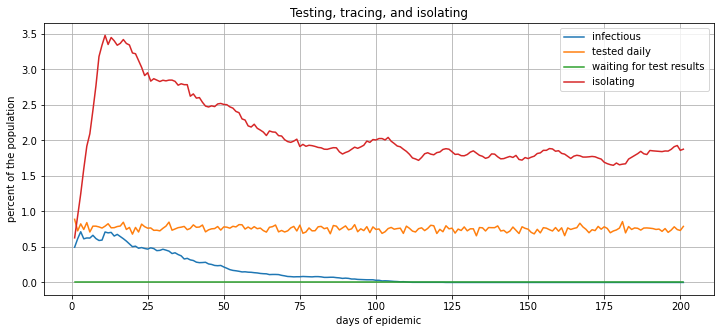

In [22]:
o_test_trace.plot(title='Testing, tracing, and isolating', secondary_y=['prop_infected'])

UK society, however, is characterized by testing bottlenecks:

In [23]:
import codit.society.alternatives as alternatives
o_UK = Outbreak(alternatives.UKSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:12:39,624 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:12:40,413 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-15 19:12:47,880 INFO:Day 51, prop infected is 0.04, prop infectious is 0.0022
2021-01-15 19:12:54,470 INFO:Day 101, prop infected is 0.05, prop infectious is 0.0004
2021-01-15 19:13:01,074 INFO:Day 151, prop infected is 0.05, prop infectious is 0.0000
2021-01-15 19:13:08,318 INFO:Day 201, prop infected is 0.05, prop infectious is 0.0000


2021-01-15 19:13:08,389 INFO: Realized R0 of early infections is 0.90
2021-01-15 19:13:08,390 INFO: 4.7 percent of the proportion was infected during the epidemic


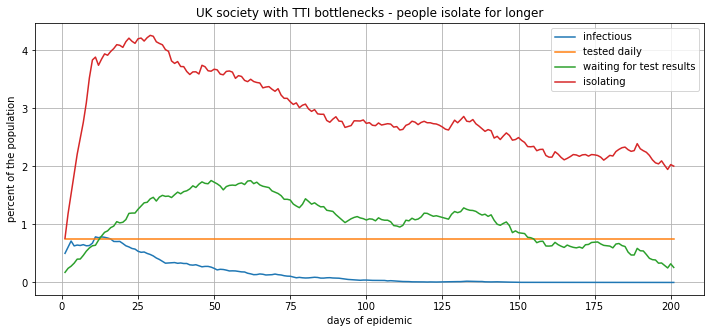

In [24]:
o_UK.plot(title='UK society with TTI bottlenecks - people isolate for longer')

In [25]:
o_contact_test = Outbreak(society.ContactTestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-15 19:13:08,581 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-15 19:13:09,389 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-15 19:13:17,159 INFO:Day 51, prop infected is 0.05, prop infectious is 0.0056
2021-01-15 19:13:24,819 INFO:Day 101, prop infected is 0.08, prop infectious is 0.0021
2021-01-15 19:13:32,836 INFO:Day 151, prop infected is 0.09, prop infectious is 0.0008
2021-01-15 19:13:39,799 INFO:Day 201, prop infected is 0.09, prop infectious is 0.0001


2021-01-15 19:13:39,881 INFO: Realized R0 of early infections is 0.98
2021-01-15 19:13:39,882 INFO: 8.9 percent of the proportion was infected during the epidemic


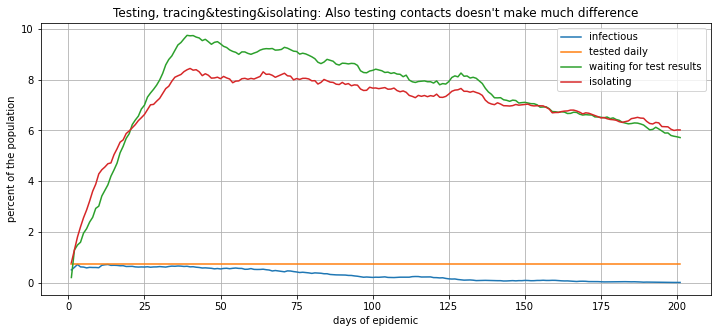

In [26]:
o_contact_test.plot(title="Testing, tracing&testing&isolating: "
                    "Also testing contacts doesn't make much difference", 
                    secondary_y=['prop_infected'])

In [27]:
infector_nets = [len(p.infector.contacts) for p in pop.people if p.infector]

In [28]:
infected_nets = [len(p.contacts) for p in pop.people if p.infected]

In [29]:
def most_connected_infector(guy):
    if guy.infector is None:
        raise NotImplementedError
    return max([len(i.contacts) for i in guy.chain() if i is not guy]) 

max_contacts_chain = [most_connected_infector(person)
                      for person in pop.people 
                      if person.infector is not None]

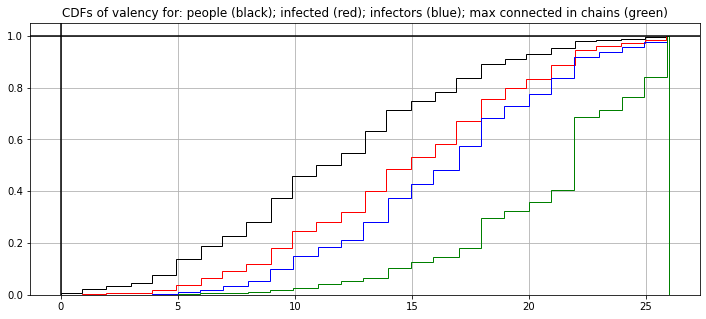

In [30]:
opts = dict(cumulative=True, bins=200, density=True, histtype='step')

plt.hist(nets, color='k', **opts)
plt.hist(infected_nets, color='r', **opts)
plt.hist(infector_nets, color='b', **opts)
plt.hist(max_contacts_chain, color='g', **opts)

plt.title("CDFs of valency for: people (black); infected (red); infectors (blue); max connected in chains (green)")
plt.axhline(1, color='k'); plt.axvline(0, color='k')
plt.grid()